In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from operator import itemgetter
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.mode.chained_assignment = None  #default='warn'

In [36]:
#Checking the dataset
df = pd.read_csv('real_estate_data_combined_cleaned_2002-2022.csv', delimiter=';')

In [11]:
df.head()

,District,Stories,Year_Built,Rooms,FinishedSqft,Units,Bdrms,Fbath,Hbath,Lotsize,...,Style_Commercial,Style_Duplex,Style_Multi-Family,Style_Other / Unknown,Style_Rooming House,Style_Single Family,EXT_Brick/Stone,EXT_Siding,EXT_Stucco,EXT_Other
0,7.0,2.0,1913.0,5.0,3476.0,4.0,9.0,1.0,0.0,5040.0,...,0,0,0,1,0,0,0,0,0,1
1,3.0,3.0,1964.0,1.0,35736.0,1.0,0.0,0.0,0.0,19100.0,...,0,0,0,1,0,0,0,0,0,1
2,3.0,2.0,1897.0,5.0,1992.0,4.0,2.0,2.0,0.0,2880.0,...,0,0,0,0,1,0,0,0,0,1
3,9.0,2.0,1980.0,1.0,31424.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,1
4,4.0,2.0,1907.0,5.0,2339.0,6.0,0.0,1.0,0.0,3185.0,...,0,0,0,0,1,0,0,0,0,1


In [37]:
#Check if df hav any missing values
df.isnull().values.any()

False

In [38]:
#See all the column names
print(df.columns.values)

['District' 'Stories' 'Year_Built' 'Rooms' 'FinishedSqft' 'Units' 'Bdrms'
 'Fbath' 'Hbath' 'Lotsize' 'Sale_date' 'Sale_price' 'Sale_year'
 'Sale_month' 'Sale_quarter' 'PropType_exempt' 'PropType_lg apartment'
 'PropType_manufacturing' 'PropType_residential' 'IsMultiUnit'
 'Style_Apartment' 'Style_Commercial' 'Style_Duplex' 'Style_Multi-Family'
 'Style_Other / Unknown' 'Style_Rooming House' 'Style_Single Family'
 'EXT_Brick/Stone' 'EXT_Siding' 'EXT_Stucco' 'EXT_Other']


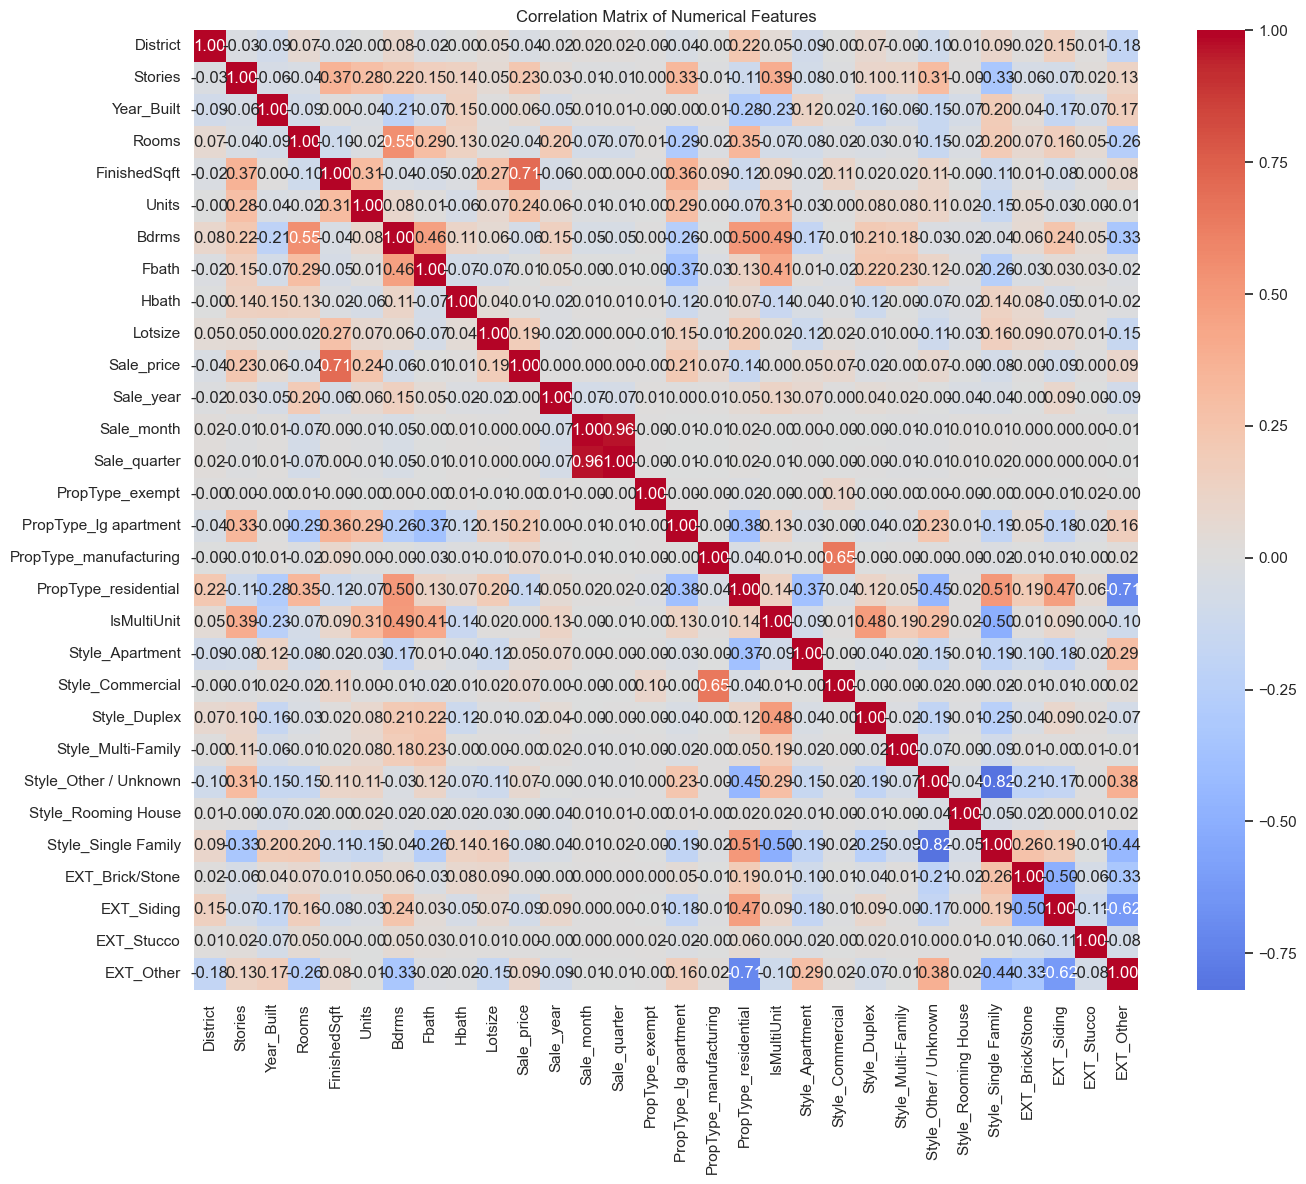

In [21]:
# Compute Pearson correlation matrix
numeric_df = df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

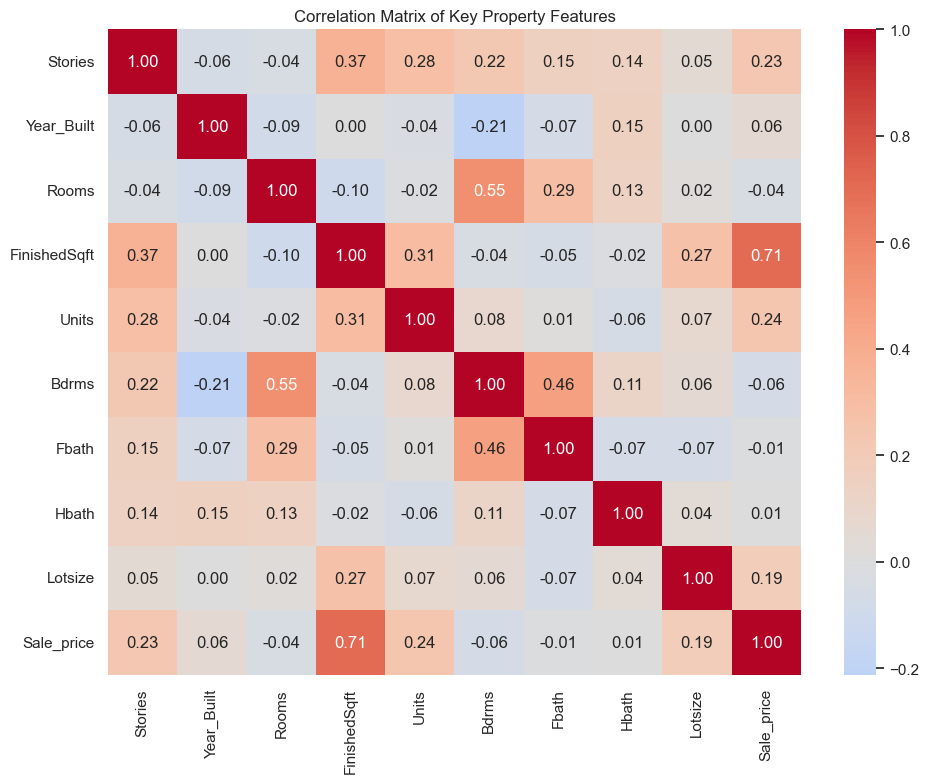

In [22]:
# Select core numeric features only to reduce the clutter
core_features = ['Stories', 'Year_Built', 'Rooms', 'FinishedSqft', 'Units', 
                 'Bdrms', 'Fbath', 'Hbath', 'Lotsize', 'Sale_price']

# Compute correlation matrix
correlation_matrix = df[core_features].corr()

# Plot heatmap updated with core features
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Key Property Features')
plt.tight_layout()
plt.show()

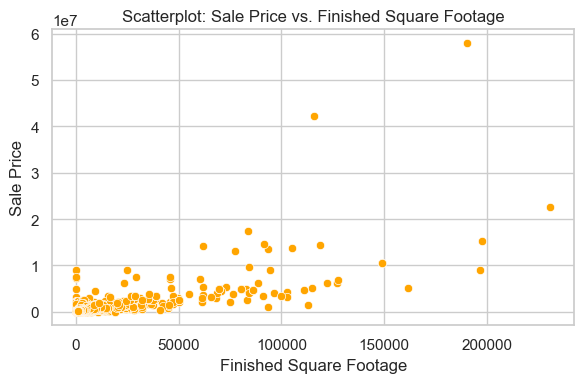

In [30]:
# Sale Price vs. Finished square footage
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x='FinishedSqft', y='Sale_price', color='orange')
plt.title('Scatterplot: Sale Price vs. Finished Square Footage')
plt.xlabel('Finished Square Footage')
plt.ylabel('Sale Price')
plt.tight_layout()
plt.show()

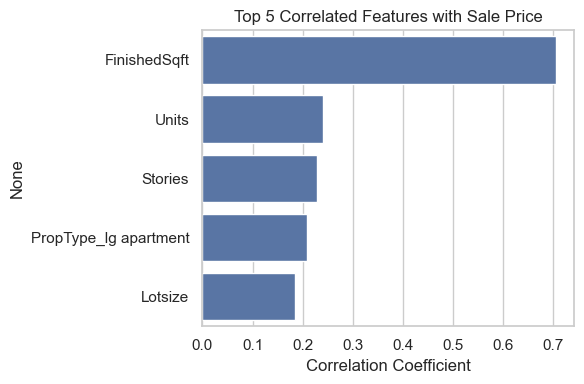

In [35]:
#Feature correlations on Sale Price
correlations = df.corr(numeric_only=True)['Sale_price'].sort_values(ascending=False)
top_corr = correlations[1:6]  # Exclude Sale_price itself

plt.figure(figsize=(6, 4))
sns.barplot(x=top_corr.values, y=top_corr.index)
plt.title('Top 5 Correlated Features with Sale Price')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

In [69]:
#convert Sale_date into numeric parts and then dropping it
df['Sale_date'] = pd.to_datetime(df['Sale_date'])
df['Sale_year'] = df['Sale_date'].dt.year
df['Sale_month'] = df['Sale_date'].dt.month
df['Sale_quarter'] = df['Sale_date'].dt.quarter

#Drop sale_price and sale_date and target definition
X = df.drop(['Sale_price', 'Sale_date'], axis=1)
y = df['Sale_price']


In [183]:
#Train Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [184]:
print('The shape of the training data is: ',X_train.shape)
print('The shape of the test data is: ',X_test.shape)

The shape of the training data is:  (44758, 29)
The shape of the test data is:  (11190, 29)


In [185]:
#Scaling numeric features (for KNN and Linear Regression)
features_to_scale = ['FinishedSqft', 'Bdrms', 'Fbath', 'Hbath', 'Stories', 'Lotsize', 'Year_Built']
scaler = MinMaxScaler()
X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])

In [186]:
#Linear regression - first try
lin_model = LinearRegression().fit(X_train, y_train)
print("Linear Regression - Train R²:", round(lin_model.score(X_train, y_train), 4))
print("Linear Regression - Test R²:", round(lin_model.score(X_test, y_test), 4))

cv_scores = cross_val_score(LinearRegression(), X_train, y_train, cv=5)
print("Linear Regression - Mean CV R²:", round(np.mean(cv_scores), 4))

Linear Regression - Train R²: 0.4916
Linear Regression - Test R²: 0.6702
Linear Regression - Mean CV R²: 0.434


In [187]:
#KNN Regression - first try
param_grid_knn = {'n_neighbors': np.arange(1, 20)}
grid_knn = GridSearchCV(KNeighborsRegressor(), param_grid_knn, cv=5)
grid_knn.fit(X_train, y_train)

print("Best KNN Parameters:", grid_knn.best_params_)
print("KNN - Train R²:", grid_knn.score(X_train, y_train))
print("KNN - Test R²:", grid_knn.score(X_test, y_test))
print("KNN - Mean CV R²:", round(grid_knn.best_score_, 4))

Best KNN Parameters: {'n_neighbors': 14}
KNN - Train R²: 0.22892138791631977
KNN - Test R²: 0.20463840406442457
KNN - Mean CV R²: 0.156


In [188]:
#Random forest regressor - first try
param_dist_rf = {
    'n_estimators': [50, 100, 150],
    'max_features': [5, 10, 15],
    'max_depth': [2, 4, 8, 10, None],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 3]
}

rand_search_rf = RandomizedSearchCV(RandomForestRegressor(), param_distributions=param_dist_rf,
                                    n_iter=10, cv=3, random_state=42)
rand_search_rf.fit(X_train, y_train)

print("Random Forest - Train R²:", rand_search_rf.score(X_train, y_train))
print("Random Forest - Test R²:", rand_search_rf.score(X_test, y_test))
print("Random Forest - Best CV Score:", rand_search_rf.best_score_)
print("Random Forest - Best Parameters:", rand_search_rf.best_params_)

Random Forest - Train R²: 0.9643525910776849
Random Forest - Test R²: 0.7522833016937143
Random Forest - Best CV Score: 0.6298869248264126
Random Forest - Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 5, 'max_depth': None}


In [189]:
#Feature importance from Random forest
from operator import itemgetter

feature_importances = list(zip(rand_search_rf.best_estimator_.feature_importances_, X_train.columns))
sorted_importances = sorted(feature_importances, key=itemgetter(0), reverse=True)

print("Top 5 Most Important Features (Random Forest):")
for importance in sorted_importances[:5]:
    print(f"{importance[1]}: {importance[0]:.4f}")

Top 5 Most Important Features (Random Forest):
FinishedSqft: 0.3057
Stories: 0.1605
Year_Built: 0.1568
Lotsize: 0.1277
District: 0.0466


In [190]:
#Improving the Lineare regression model - SelectKBest
# 1. Select top 10 features
selector = SelectKBest(f_regression, k=10)
X_train_best = selector.fit_transform(X_train, y_train)
X_test_best = selector.transform(X_test)

# 2. Re-train linear regression
lin_model_best = LinearRegression().fit(X_train_best, y_train)

# 3. Evaluate again
print("Linear Regression (Best 10 features) - Train R²:", round(lin_model_best.score(X_train_best, y_train), 4))
print("Linear Regression (Best 10 features) - Test R²:", round(lin_model_best.score(X_test_best, y_test), 4))

cv_scores_best = cross_val_score(LinearRegression(), X_train_best, y_train, cv=5)
print("Linear Regression (Best 10 features) - Mean CV R²:", round(np.mean(cv_scores_best), 4))

# Optional: Show which features were selected
selected_features = X_train.columns[selector.get_support()]
print("Top 10 selected features:", list(selected_features))

Linear Regression (Best 10 features) - Train R²: 0.4849
Linear Regression (Best 10 features) - Test R²: 0.6604
Linear Regression (Best 10 features) - Mean CV R²: 0.4297
Top 10 selected features: ['Stories', 'FinishedSqft', 'Units', 'Lotsize', 'PropType_lg apartment', 'PropType_residential', 'Style_Other / Unknown', 'Style_Single Family', 'EXT_Siding', 'EXT_Other']


In [191]:
#Improving the KNN regression model - SelectKBest

# Use the same selector from earlier
X_train_knn = X_train_best
X_test_knn = X_test_best

# Re-train KNN with top 10 features
knn_model_best = KNeighborsRegressor(n_neighbors=5)
knn_model_best.fit(X_train_knn, y_train)

# Evaluate KNN
print("KNN (Best 10 features) - Train R²:", round(knn_model_best.score(X_train_knn, y_train), 4))
print("KNN (Best 10 features) - Test R²:", round(knn_model_best.score(X_test_knn, y_test), 4))

from sklearn.model_selection import cross_val_score
cv_scores_knn = cross_val_score(knn_model_best, X_train_knn, y_train, cv=5)
print("KNN (Best 10 features) - Mean CV R²:", round(np.mean(cv_scores_knn), 4))

KNN (Best 10 features) - Train R²: 0.5397
KNN (Best 10 features) - Test R²: 0.527
KNN (Best 10 features) - Mean CV R²: 0.3163


In [192]:
# Improving the KNN regression model - GridSearchCV using best 10 features
param_grid_knn = {'n_neighbors': np.arange(1, 20)}
grid_knn_best = GridSearchCV(KNeighborsRegressor(), param_grid_knn, cv=5)
grid_knn_best.fit(X_train_best, y_train)
y_predict_knn_grid = grid_knn_best.predict(X_to_predict_best)

print("Best KNN Parameters:", grid_knn_best.best_params_)
print("KNN (GridSearch + Top 10) – Train R²:", round(grid_knn_best.score(X_train_best, y_train), 4))
print("KNN (GridSearch + Top 10) – Test R²:", round(grid_knn_best.score(X_test_best, y_test), 4))
print("KNN (GridSearch + Top 10) – Mean CV R²:", round(grid_knn_best.best_score_, 4))

Best KNN Parameters: {'n_neighbors': 11}
KNN (GridSearch + Top 10) – Train R²: 0.4478
KNN (GridSearch + Top 10) – Test R²: 0.6237
KNN (GridSearch + Top 10) – Mean CV R²: 0.4184


In [217]:
#Improve Random forest

#Define parameter grid
param_dist_rf = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

#Create RandomizedSearchCV
rand_search_rf = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist_rf,
    n_iter=20,
    cv=5,
    random_state=42,
    n_jobs=-1
)

#Fit on SelectKBest-reduced training data
rand_search_rf.fit(X_train_best, y_train)

#Evaluate the model
print("Random Forest – Train R²:", round(rand_search_rf.score(X_train_best, y_train), 4))
print("Random Forest – Test R²:", round(rand_search_rf.score(X_test_best, y_test), 4))
print("Random Forest – Best CV Score:", round(rand_search_rf.best_score_, 4))
print("Random Forest – Best Parameters:", rand_search_rf.best_params_)

Random Forest – Train R²: 0.8401
Random Forest – Test R²: 0.6655
Random Forest – Best CV Score: 0.5268
Random Forest – Best Parameters: {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}


In [205]:
#Take 3 random rows from test set
sample = X_test.sample(3, random_state=42)
prediction_data = sample.copy()
prediction_data['Sale_price'] = y_test.loc[sample.index]

prediction_data.to_csv("prediction_data.csv", index=False)

y_true = prediction_data['Sale_price']

In [206]:
#Prediction on 3 specific properties
prediction_data = pd.read_csv('prediction_data.csv')
prediction_data[features_to_scale] = scaler.transform(prediction_data[features_to_scale])

print("\nPredicting sale prices on new data...")



Predicting sale prices on new data...


In [207]:
# Load and prepare prediction data
prediction_data = pd.read_csv('prediction_data.csv')

# Scale numeric features
prediction_data[features_to_scale] = scaler.transform(prediction_data[features_to_scale])

# Extract y and drop target column
y_true = prediction_data['Sale_price']
X_to_predict = prediction_data.drop('Sale_price', axis=1)

# Apply SelectKBest (same selector from earlier)
X_to_predict_best = selector.transform(X_to_predict)

In [208]:
# Linear Regression (Top 10 features)
y_predict_lin_best = lin_model_best.predict(X_to_predict_best)
print("\nLinear Regression Predictions (Top 10 features):")
for pred in y_predict_lin_best:
    print(f"{pred:,.2f} USD")


Linear Regression Predictions (Top 10 features):
34,820.88 USD
34,820.91 USD
128,577.55 USD


In [209]:
# KNN (GridSearch + Top 10 features)
y_predict_knn_grid = grid_knn_best.predict(X_to_predict_best)
print("\nKNN Predictions (GridSearch + Top 10 features):")
for pred in y_predict_knn_grid:
    print(f"{pred:,.2f} USD")


KNN Predictions (GridSearch + Top 10 features):
104,445.45 USD
104,445.45 USD
504,272.73 USD


In [225]:
# Random Forest
y_predict_rf_best = rand_search_rf.predict(X_to_predict_best)
print("\nRandom Forest Predictions:")
for pred in y_predict_rf:
    print(f"{pred:,.2f} USD")


Random Forest Predictions:
345,132.00 USD
333,748.00 USD
467,136.21 USD


In [227]:
# 5. Create comparison table (with SelectKBest models)
comparison_df_best = pd.DataFrame({
    'Actual Price (USD)': y_true,
    'Linear Regression (Top 10)': y_predict_lin_best,
    'KNN (Gridsearch + Top 10)': y_predict_knn_grid,
    'Random Forest': y_predict_rf
}).round(2)

In [228]:
# 7. Round and display predictions
display(comparison_df_best)

,Actual Price (USD),Linear Regression (Top 10),KNN (Gridsearch + Top 10),Random Forest
0,145000.0,34820.88,104445.45,345132.00
1,142000.0,34820.91,104445.45,333748.00
2,142000.0,128577.55,504272.73,467136.21


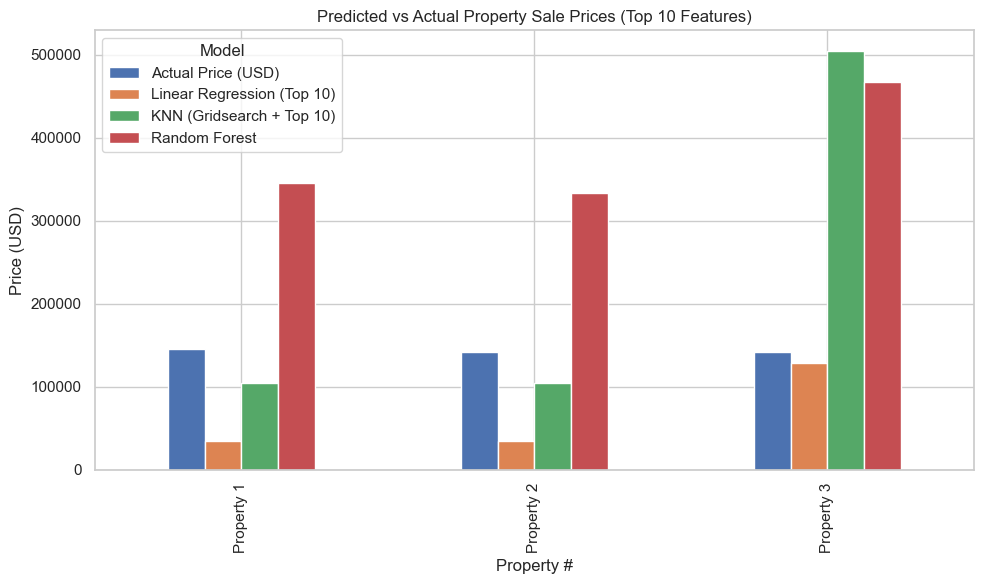

In [229]:
# Reset index for plotting
comparison_df_plot = comparison_df_best.reset_index(drop=True)

# Plot bar chart
comparison_df_plot.plot(kind='bar', figsize=(10, 6))
plt.title('Predicted vs Actual Property Sale Prices (Top 10 Features)')
plt.xlabel('Property #')
plt.ylabel('Price (USD)')
plt.xticks(ticks=range(len(comparison_df_plot)), labels=[f'Property {i+1}' for i in range(len(comparison_df_plot))])
plt.legend(title='Model')
plt.tight_layout()
plt.grid(True)
plt.show()